 *Import Necessary Libraries*

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import gensim
import calendar
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.impute import SimpleImputer

# Load and Normalize Movie Data

Load and Normalize Album Data

In [143]:
# Load and normalize movie data
filename_movies =r'C:\Users\alex-\OneDrive\Ambiente de Trabalho\media\media\movies.json'
with open(filename_movies, 'r') as file:  # Open file in read mode
    data = json.load(file)  # Load JSON data from file
# Extract 'movie' section from each data entry
movie_data = [movie['data']['movie'] for movie in data.values()]


# Normalize the data and convert to DataFrame
flat_data_movies = pd.json_normalize(movie_data)
# Drop rows with all missing values
flat_data_movies = flat_data_movies.dropna(how='all')
print(flat_data_movies.tail())

flat_data_movies.info()


                title  criticScore  year           director   
130       The Phantom         53.0  1996     [Simon Wincer]  \
131       The Postman         29.0  1997    [Kevin Costner]   
132  The Ridiculous 6         18.0  2015     [Frank Coraci]   
133       The Snowman         23.0  2017  [Tomas Alfredson]   
136    The Wicker Man         36.0  2006      [Neil LaBute]   

           releaseDate     genres   
130       June 7, 1996   [Comedy]  \
131  December 25, 1997    [Drama]   
132  December 11, 2015  [Western]   
133   October 20, 2017    [Crime]   
136  September 1, 2006   [Horror]   

                                                  cast     rating  runtime   
130  [Bill Smitrovich, Billy Zane, Cary-Hiroyuki Ta...         PG  100 min  \
131  [Kevin Costner, Larenz Tate, Olivia Williams, ...          R  177 min   
132                                                 []  Not Rated  119 min   
133  [Charlotte Gainsbourg, Chloë Sevigny, David De...          R  119 min   
136     

In [171]:
# Load and normalize album data
filename_albums = r'C:\Users\alex-\OneDrive\Ambiente de Trabalho\media\media\albums.json'
with open(filename_albums, 'r') as file:  # Open file in read mode
    data = json.load(file)  # Load JSON data from file
# Preprocess data to ensure 'album' is at the same level for all entries
preprocessed_data = []
for album in data.values():
    if 'data' in album and 'album' in album['data']:
        preprocessed_data.append(album['data']['album'])
    else:
        preprocessed_data.append(album)
# Normalize the data and convert to DataFrame
flat_data_albums = pd.json_normalize(preprocessed_data)
# Rename some columns to match movie data
flat_data_albums = flat_data_albums.rename(columns={'album': 'title', 'releaseDate': 'year'})



 Load and Normalize TV Show Data

In [145]:
filename_tv_shows = r'C:\Users\alex-\OneDrive\Ambiente de Trabalho\media\media\tv-shows.json'
with open(filename_tv_shows, 'r') as file:  # Open file in read mode
    data = json.load(file)  # Load JSON data from file
# Print keys of the first item
#for key, value in list(data.items())[:5]:  # Print the first 5 entries
    #print(f"Key: {key}")
    #print(f"Value: {value}\n")
# Extract 'tvshow' section from each data entry, if it exists
tv_show_data = [show['data']['tvshow'] for show in data.values() if 'data' in show and 'tvshow' in show['data']]

# Normalize the data and convert to DataFrame
flat_data_tv_show = pd.json_normalize(tv_show_data)

# Drop rows with all missing values
flat_data_tv_show = flat_data_tv_show.dropna(how='all')
print(flat_data_tv_show.tail())
flat_data_tv_show.info()

Empty DataFrame
Columns: []
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


Data Preprocessing

In [146]:
# Concatenate movie and album DataFrames
df = pd.concat([flat_data_albums, flat_data_movies, flat_data_tv_show], ignore_index=True)

# Drop rows where 'criticScore' is missing
df = df.dropna(subset=["criticScore"])
analysis_df = pd.concat([flat_data_albums, flat_data_movies, flat_data_tv_show], ignore_index=True)
analysis_df = analysis_df.dropna(subset=["criticScore"])
# Categorize 'criticScore' into four categories
def categorize_score(score):
    if pd.isna(score):
        return score
    elif score <= 39:
        return 'bad'
    elif score <= 69:
        return 'mediocre'
    elif score <= 89:
        return 'good'
    else:
        return 'excellent'

# Apply the categorization function to the 'criticScore' column
df['criticScore'] = df['criticScore'].apply(categorize_score)

# Print the last few rows of the DataFrame
print(df.tail())


                title artist criticScore  year     genres publisher   
188       The Phantom    NaN    mediocre  1996   [Comedy]       NaN  \
189       The Postman    NaN         bad  1997    [Drama]       NaN   
190  The Ridiculous 6    NaN         bad  2015  [Western]       NaN   
191       The Snowman    NaN         bad  2017    [Crime]       NaN   
192    The Wicker Man    NaN         bad  2006   [Horror]       NaN   

     numOfCriticReviews           director        releaseDate   
188                22.0     [Simon Wincer]       June 7, 1996  \
189                14.0    [Kevin Costner]  December 25, 1997   
190                12.0     [Frank Coraci]  December 11, 2015   
191                40.0  [Tomas Alfredson]   October 20, 2017   
192                19.0      [Neil LaBute]  September 1, 2006   

                                                  cast     rating  runtime   
188  [Bill Smitrovich, Billy Zane, Cary-Hiroyuki Ta...         PG  100 min  \
189  [Kevin Costner, Laren

Data Visualization of critic Score

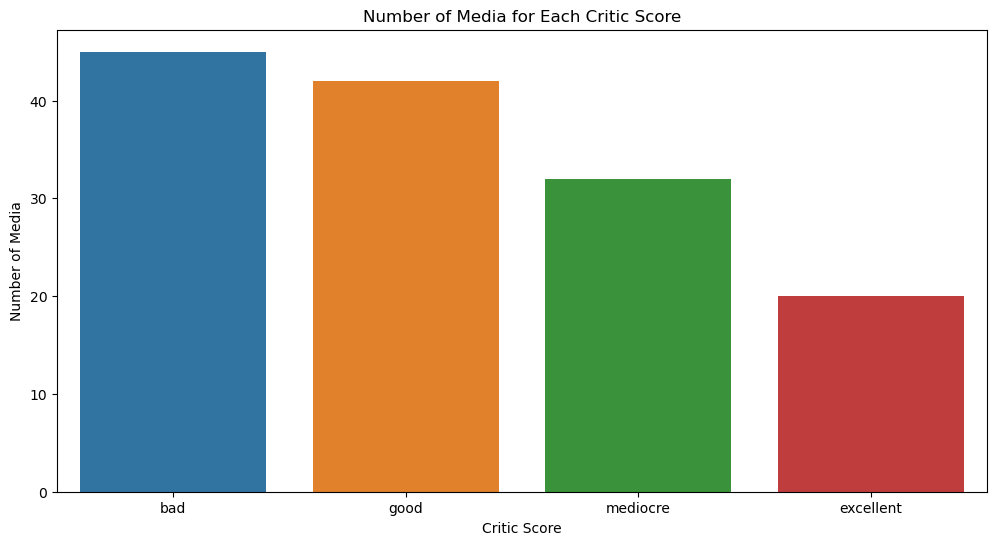

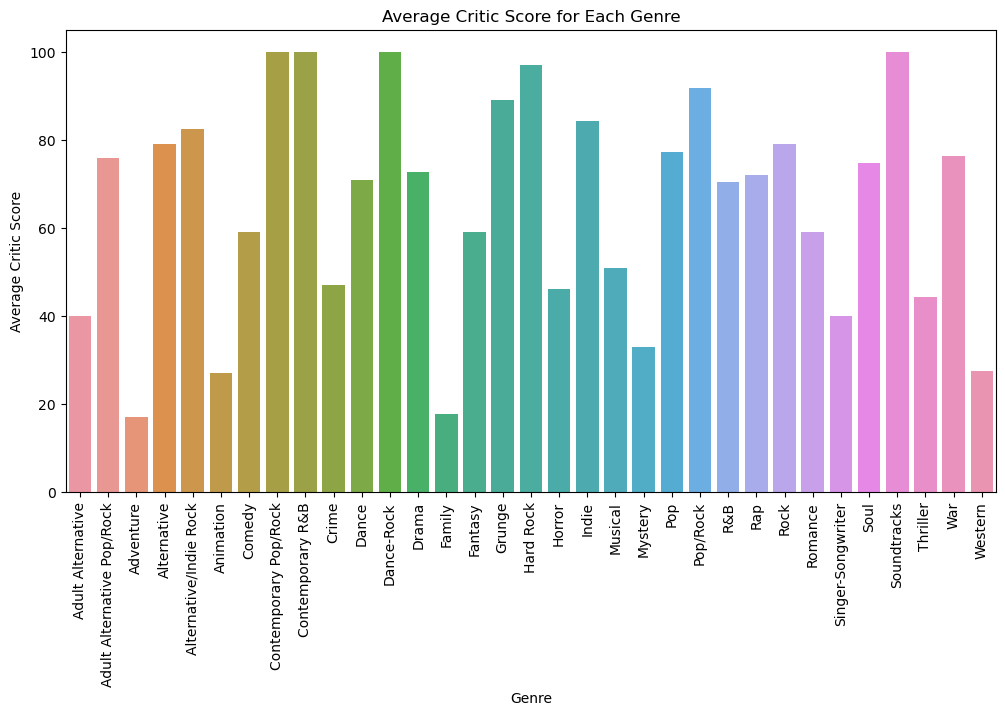

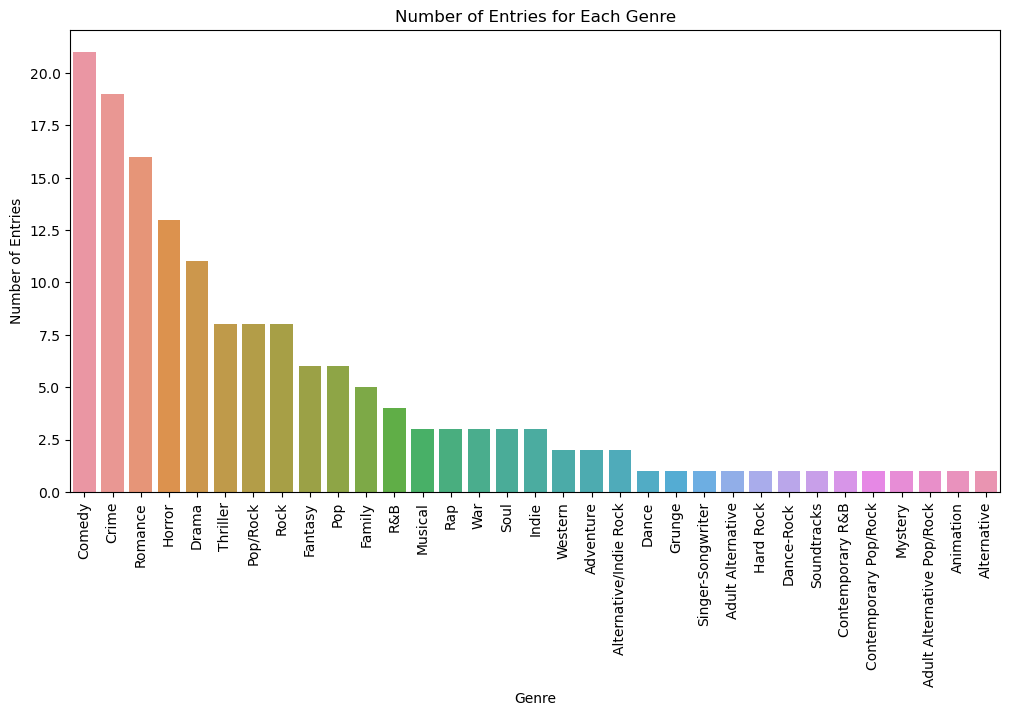

In [147]:
# Count the number of each criticScore value
criticScore_counts = df['criticScore'].value_counts()

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=criticScore_counts.index, y=criticScore_counts.values)
plt.xlabel('Critic Score')
plt.ylabel('Number of Media')
plt.title('Number of Media for Each Critic Score')
plt.show()


# Explode the genre columns
df_genres = analysis_df.explode('genres')

genre_scores = df_genres.groupby('genres')['criticScore'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=genre_scores.index, y=genre_scores.values)
plt.xlabel('Genre')
plt.ylabel('Average Critic Score')
plt.title('Average Critic Score for Each Genre')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

#Compute the number of entries for each genre
genre_counts = df_genres['genres'].value_counts()

#Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Entries')
plt.title('Number of Entries for Each Genre')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

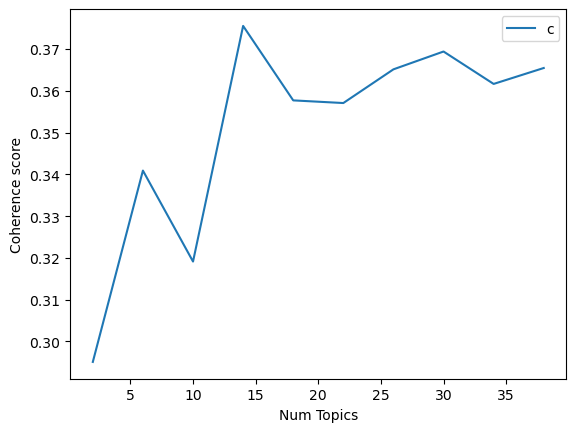

In [148]:
#nltk.download('punkt')
from gensim import corpora
# Create a list of English stop words
stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words())

# Add your own additional stop words
additional_stop_words = ['series', 'new', 'life', 'based', 'set', 'film', 'day', 'like', 'comedy', 'drama', 'friends', 'season', 'story', 'man', 'best', 'family', 's']
stop_words.extend(additional_stop_words)

# Create a list of texts from the dataframe
texts = [nltk.word_tokenize(text) for text in df['summary'].dropna()]

# Lowercase all words and remove stop words and punctuation from the list of texts
texts = [[word.lower() for word in text if word.lower() not in stop_words and word.isalpha()] for text in texts]

# Create a dictionary from the texts
id2word = corpora.Dictionary(texts)

# Filter extremes
id2word.filter_extremes(no_below=5, no_above=0.5)

# Create a gensim corpus
corpus = [id2word.doc2bow(text) for text in texts]

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=4)

# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [159]:
import pyLDAvis.gensim_models

# Create an LDA model with the optimal number of topics you found
optimal_num_topics = 24 
lda = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=optimal_num_topics, passes=10, workers=4)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, id2word, n_jobs=1)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.034641  0.013272       1        1  14.432551
12     0.120866  0.069404       2        1   8.719177
15    -0.129185  0.122487       3        1   8.162689
7      0.243861 -0.071588       4        1   6.521731
5     -0.037184 -0.090644       5        1   6.476914
0      0.049905  0.224156       6        1   6.000671
10     0.054447 -0.110877       7        1   5.058456
16    -0.254976 -0.113017       8        1   4.492986
21    -0.193397  0.129248       9        1   3.980133
14    -0.004958  0.012860      10        1   3.896479
3      0.246100 -0.028556      11        1   3.867575
20     0.185780  0.038291      12        1   3.533360
19    -0.086973 -0.179478      13        1   3.424579
13     0.002959 -0.214959      14        1   3.027753
1      0.053586 -0.014328      15        1   2.802528
2     -0.107114  0.108708      16        1   2.673828
8     -0.167615  0.074764      17        1   2.512953
6     -0.119225 -0.127485      18        1   2.480777
18    -0.029542  0.052034      19        1   2.287728
22     0.052108 -0.007973      20        1   2.062502
23     0.094736  0.093444      21        1   1.547702
4     -0.002940  0.006746      22        1   0.678976
11    -0.002940  0.006746      23        1   0.678976
9     -0.002940  0.006746      24        1   0.678976, topic_info=        Term       Freq      Total Category  logprob  loglift
25      help   8.000000   8.000000  Default  30.0000  30.0000
22     young   8.000000   8.000000  Default  29.0000  29.0000
9   american   8.000000   8.000000  Default  28.0000  28.0000
19     world  17.000000  17.000000  Default  27.0000  27.0000
20     crime   6.000000   6.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
3   pictures   0.048849  12.862313  Topic24  -3.5835  -0.5810
8       wife   0.048849   9.783432  Topic24  -3.5835  -0.3074
9   american   0.048849   8.961399  Topic24  -3.5835  -0.2196
19     world   0.048849  17.678658  Topic24  -3.5835  -0.8990
25      help   0.048849   8.704966  Topic24  -3.5835  -0.1906

[870 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         1  0.111590  american
9         8  0.446359  american
9         9  0.223179  american
9        17  0.111590  american
9        18  0.111590  american
...     ...       ...       ...
22        6  0.116599     young
22        9  0.116599     young
22       10  0.116599     young
22       16  0.349796     young
22       17  0.116599     young

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 13, 16, 8, 6, 1, 11, 17, 22, 15, 4, 21, 20, 14, 2, 3, 9, 7, 19, 23, 24, 5, 12, 10])

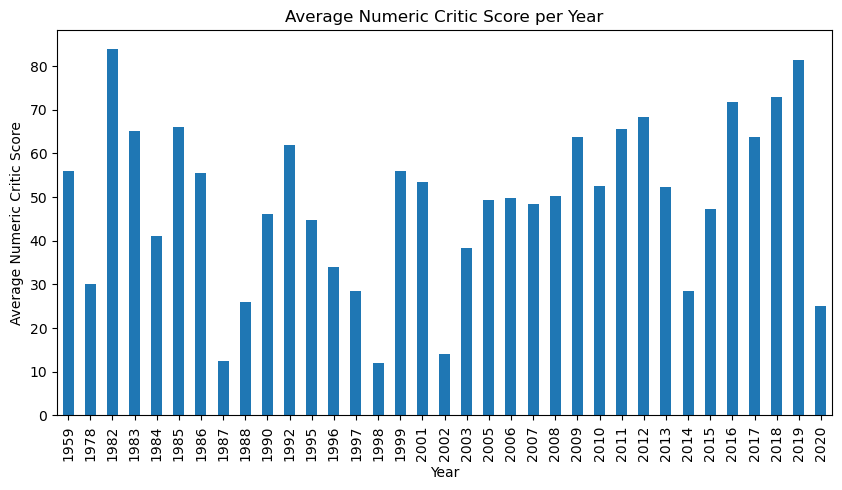

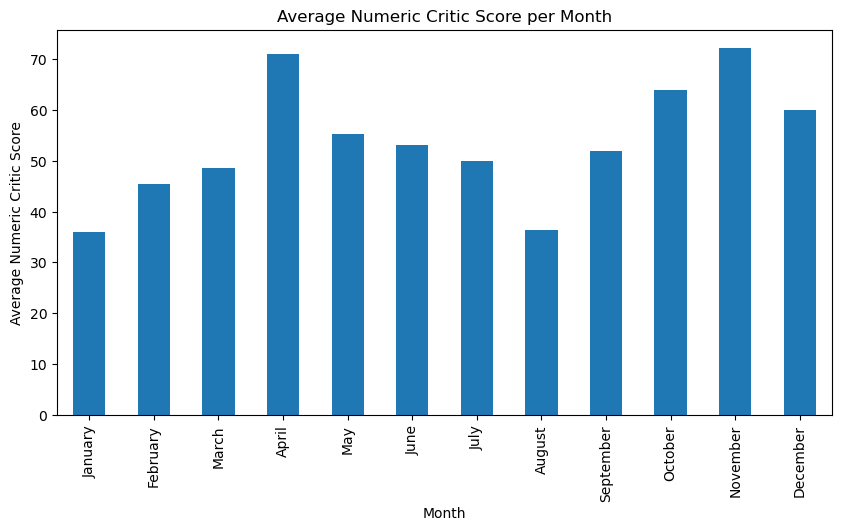

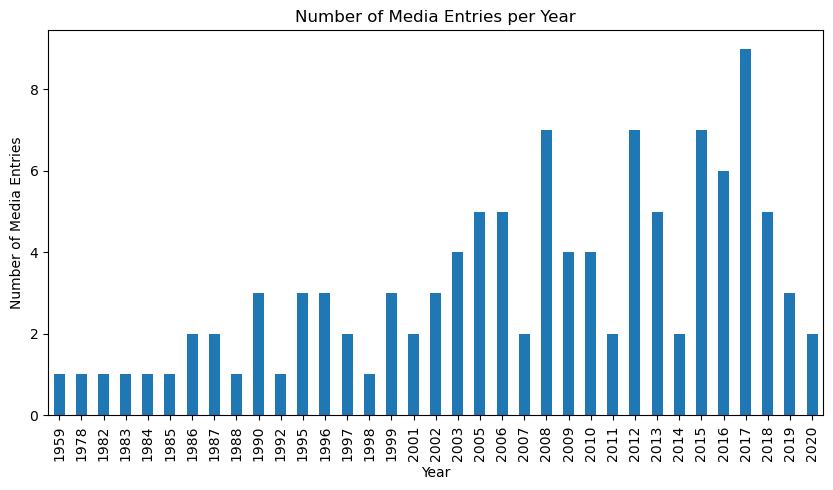

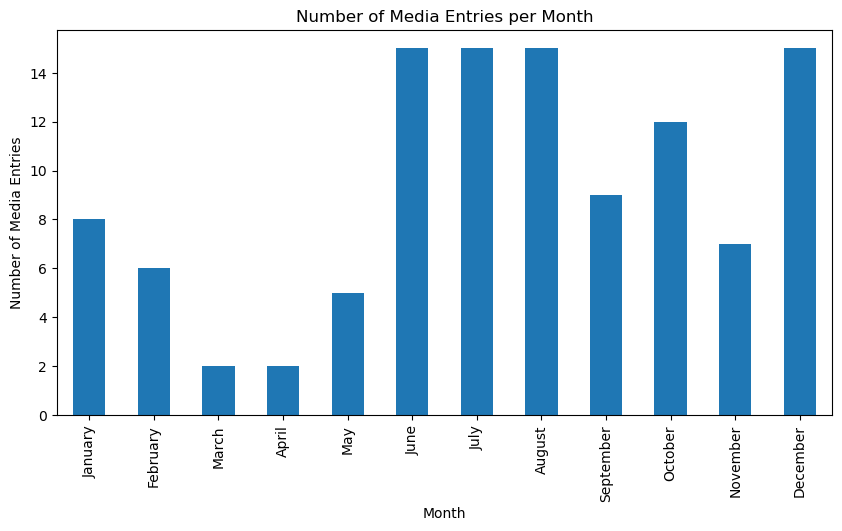

In [150]:
import calendar
analysis_df['releaseDate'] = pd.to_datetime(analysis_df['releaseDate'])
analysis_df['releaseYear'] = analysis_df['releaseDate'].dt.year
analysis_df['releaseMonth'] = analysis_df['releaseDate'].dt.month


avg_score_per_year = analysis_df.groupby('releaseYear')['criticScore'].mean()
avg_score_per_month = analysis_df.groupby('releaseMonth')['criticScore'].mean()

# Plot average critic score per year
plt.figure(figsize=(10, 5))
avg_score_per_year.plot(kind='bar', x=avg_score_per_year.index.astype(int))
plt.title('Average Numeric Critic Score per Year')
plt.xlabel('Year')
plt.ylabel('Average Numeric Critic Score')
plt.xticks(np.arange(len(avg_score_per_year)), avg_score_per_year.index.astype(int), rotation=90)  # Update x-ticks to integers
plt.show()

# Map month numbers to names
avg_score_per_month.index = avg_score_per_month.index.astype(int).map(lambda x: calendar.month_name[x])

# Plot average critic score per month
plt.figure(figsize=(10, 5))
avg_score_per_month.plot(kind='bar')
plt.title('Average Numeric Critic Score per Month')
plt.xlabel('Month')
plt.ylabel('Average Numeric Critic Score')
plt.show()

# Group by releaseYear and count the number of entries
media_per_year = analysis_df.groupby('releaseYear').size()

# Plot
plt.figure(figsize=(10, 5))
media_per_year.plot(kind='bar')
plt.title('Number of Media Entries per Year')
plt.xlabel('Year')
plt.ylabel('Number of Media Entries')
plt.xticks(np.arange(len(avg_score_per_year)), avg_score_per_year.index.astype(int), rotation=90)  # Update x-ticks to integers
plt.show()

# Group by releaseYear and count the number of entries
media_per_month = analysis_df.groupby('releaseMonth').size()
media_per_month.index = media_per_month.index.astype(int).map(lambda x: calendar.month_name[x])
# Plot
plt.figure(figsize=(10, 5))
media_per_month.plot(kind='bar')
plt.title('Number of Media Entries per Month')
plt.xlabel('Month')
plt.ylabel('Number of Media Entries')
plt.show()


Top 20 Pairs of Cast Members with the Best Average Score:
                       cast_pairs  avg_score  movie_count   
0  (Kathryn Newton, Lucas Hedges)       90.5            2  \
1    (Amy Adams, Joaquin Phoenix)       88.5            2   

                                              movies qualitative_score  
0  [Lady Bird, Three Billboards Outside Ebbing, M...         excellent  
1                                  [The Master, Her]              good  

Top 20 Actors with the Best Average Score:
                  cast  avg_score  movie_count   
0         Lucas Hedges       90.5            2  \
1       Kathryn Newton       90.5            2   
2        Saoirse Ronan       90.5            2   
3   Caleb Landry Jones       90.0            2   
4            Amy Adams       88.5            2   
5      Joaquin Phoenix       88.5            2   
6        Toni Collette       83.5            2   
7    Michelle Williams       80.5            2   
8            Brad Pitt       77.0           

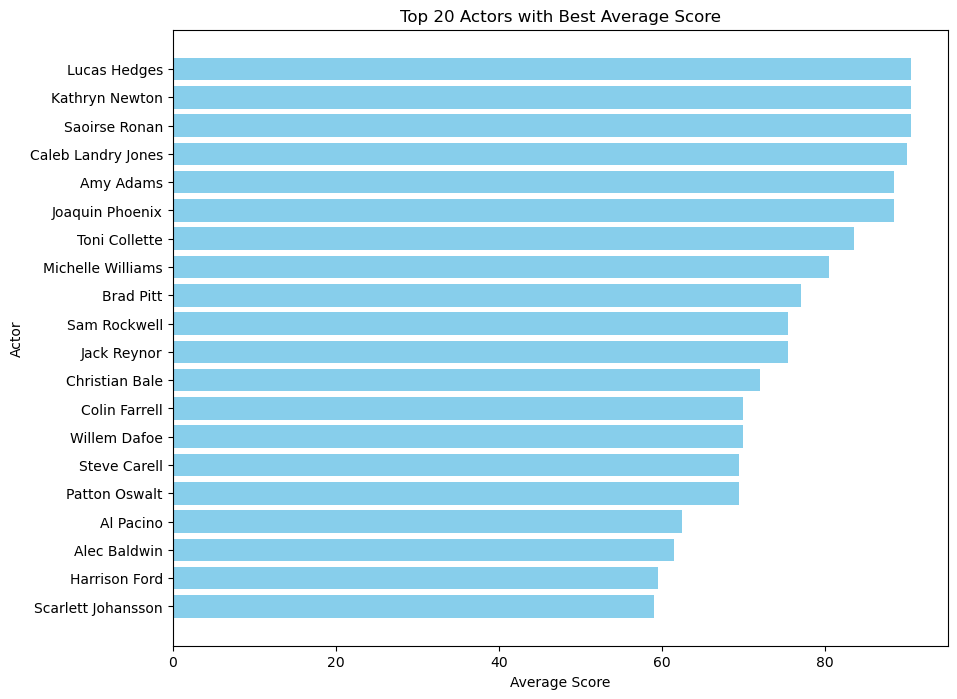

In [151]:
import itertools
def calculate_scores(grouped_data):
    df = grouped_data.agg({'criticScore': 'mean', 'title': ['count', lambda x: list(set(x))]})
    df.columns = ['avg_score', 'movie_count', 'movies']
    df = df[df['movie_count'] >= 2]  # At least 2 movies
    df = df[df['movies'].apply(lambda x: len(x) > 1)]  # Movies are different
    if 'avg_score' in df.columns:
        df = df.sort_values('avg_score', ascending=False).reset_index()
    return df

def create_pairs(cast):
    if isinstance(cast, list):
        return [tuple(sorted(pair)) for pair in itertools.combinations(cast, 2)]
    else:
        return []

# Explode the cast column
exploded_df = flat_data_movies.explode('cast')

# Calculate scores for each actor
actor_scores = calculate_scores(exploded_df.groupby('cast'))

flat_data_movies['cast_pairs'] = flat_data_movies['cast'].apply(create_pairs)
pair_scores = calculate_scores(flat_data_movies.explode('cast_pairs').groupby('cast_pairs'))

# Add the qualitative score
actor_scores['qualitative_score'] = actor_scores['avg_score'].apply(categorize_score)
pair_scores['qualitative_score'] = pair_scores['avg_score'].apply(categorize_score)

# Print results
print("\nTop 20 Pairs of Cast Members with the Best Average Score:")
print(pair_scores.head(20))

print("\nTop 20 Actors with the Best Average Score:")
print(actor_scores.head(20))

top_actors = actor_scores.head(20)

plt.figure(figsize=(10,8))
plt.barh(top_actors['cast'], top_actors['avg_score'], color='skyblue')
plt.xlabel('Average Score')
plt.ylabel('Actor')
plt.title('Top 20 Actors with Best Average Score')
plt.gca().invert_yaxis() # To display the highest score at the top
plt.show()


# MultinomialNB

In [112]:

df['genres'] = df['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

def stringify_if_list(x):
    if isinstance(x, list):
        return ', '.join(x)
    else:
        return x

for col in ['artist', 'publisher', 'director', 'releaseDate', 'cast', 'rating']:
    df[col] = df[col].apply(stringify_if_list)

# Now proceed with your imputation code

def stringify_genres(x):
    try:
        iter(x)  # Check if it's iterable
        return ', '.join(x)
    except TypeError:
        return x  # If it's not iterable, return it as is

df['genres'] = df['genres'].apply(stringify_genres)

# Define imputers
mean_imputer = SimpleImputer(strategy='mean')  # for numerical columns
mode_imputer = SimpleImputer(strategy='most_frequent')  # for categorical columns
constant_imputer = SimpleImputer(strategy='constant', fill_value='')  # for text columns

# Impute missing values
df['summary'] = constant_imputer.fit_transform(df['summary'].values.reshape(-1, 1))[:, 0]


df[['artist', 'publisher', 'director', 'releaseDate', 'cast', 'rating', 'year', 'runtime']] = mode_imputer.fit_transform(df[['artist', 'publisher', 'director', 'releaseDate', 'cast', 'rating', 'year', 'runtime']])
df['summary'] = constant_imputer.fit_transform(df['summary'].values.reshape(-1, 1))[:,0]

# Drop rows where 'criticScore' is NaN
df = df.dropna(subset=['criticScore'])



score_mapping = {'bad': 1, 'mediocre': 2, 'good': 3, 'excellent': 4}
df['criticScore'] = df['criticScore'].map(score_mapping)

# Create a consistent DataFrame for features and target variable
consistent_df = df.dropna(subset=['criticScore'])  # Assuming 'criticScore' is your target variable
vectorizer = TfidfVectorizer()


# Now, create X and Y from consistent_df
X = vectorizer.fit_transform(consistent_df['summary'])  # This ensures that only the rows in consistent_df are used
Y = consistent_df['criticScore']  # Now, Y will also only have the rows that are present in consistent_df
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

model = MultinomialNB()

model.fit(X_train, Y_train)

Y_pred_mn = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred_mn)
print("Mean Absolute Error: ", mae)

print("Accuracy: ", accuracy_score(Y_test, Y_pred_mn))

print(classification_report(Y_test, Y_pred_mn))
print(confusion_matrix(Y_test, Y_pred_mn))

Mean Absolute Error:  1.2142857142857142
Accuracy:  0.35714285714285715
              precision    recall  f1-score   support

           1       0.36      1.00      0.53        10
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         2

    accuracy                           0.36        28
   macro avg       0.09      0.25      0.13        28
weighted avg       0.13      0.36      0.19        28

[[10  0  0  0]
 [ 4  0  0  0]
 [12  0  0  0]
 [ 2  0  0  0]]


C:\Users\alex-\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [164]:


# Identify categorical and numerical features
categorical_features = ['artist', 'publisher', 'director', 'releaseDate', 'cast', 'rating', 'year', 'runtime']
numerical_features = ['numOfCriticReviews']
text_features = ['summary']

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_features),
        ('text', TfidfVectorizer(), 'summary')  # TfidfVectorizer needs to be applied on a 1D array
    ])

# Combine preprocessor with classifier
model_lr= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Create X and Y
X = consistent_df[categorical_features + numerical_features + text_features]
Y = consistent_df['criticScore']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
model_lr.fit(X_train, Y_train)

# Predict and calculate accuracy
Y_pred_lr = model_lr.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred_lr)
print("Mean Absolute Error: ", mae)
print("Accuracy: ", accuracy_score(Y_test, Y_pred_lr))
print(classification_report(Y_test, Y_pred_lr))
print(confusion_matrix(Y_test, Y_pred_lr))


Mean Absolute Error:  0.75
Accuracy:  0.42857142857142855
              precision    recall  f1-score   support

           1       0.54      0.70      0.61        10
           2       0.00      0.00      0.00         4
           3       0.50      0.33      0.40        12
           4       0.20      0.50      0.29         2

    accuracy                           0.43        28
   macro avg       0.31      0.38      0.32        28
weighted avg       0.42      0.43      0.41        28

[[7 2 1 0]
 [2 0 2 0]
 [4 0 4 4]
 [0 0 1 1]]


# SVM

In [165]:




# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(), 'summary')  # TfidfVectorizer needs to be applied on a 1D array
    ])

# Combine preprocessor with classifier
model_svm= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm.SVC())
])

# Create X and Y
X = consistent_df[categorical_features + numerical_features + text_features]
Y = consistent_df['criticScore']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the model
model_svm.fit(X_train, Y_train)

# Predict and calculate accuracy
Y_pred_svm = model_svm.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred_svm)
print("Mean Absolute Error: ", mae)
print("Accuracy: ", accuracy_score(Y_test, Y_pred_svm))
print(classification_report(Y_test, Y_pred_svm))
print(confusion_matrix(Y_test, Y_pred_svm))

Mean Absolute Error:  0.6785714285714286
Accuracy:  0.42857142857142855
              precision    recall  f1-score   support

           1       0.64      0.70      0.67        10
           2       0.00      0.00      0.00         4
           3       0.50      0.33      0.40        12
           4       0.25      0.50      0.33         2

    accuracy                           0.43        28
   macro avg       0.35      0.38      0.35        28
weighted avg       0.46      0.43      0.43        28

[[7 2 1 0]
 [2 0 2 0]
 [2 3 4 3]
 [0 0 1 1]]


# Decision Tree

Mean Absolute Error:  0.5357142857142857
Accuracy:  0.5357142857142857
              precision    recall  f1-score   support

           1       0.67      0.60      0.63        10
           2       0.14      0.25      0.18         4
           3       0.70      0.58      0.64        12
           4       0.50      0.50      0.50         2

    accuracy                           0.54        28
   macro avg       0.50      0.48      0.49        28
weighted avg       0.59      0.54      0.56        28

[[6 3 1 0]
 [2 1 1 0]
 [1 3 7 1]
 [0 0 1 1]]


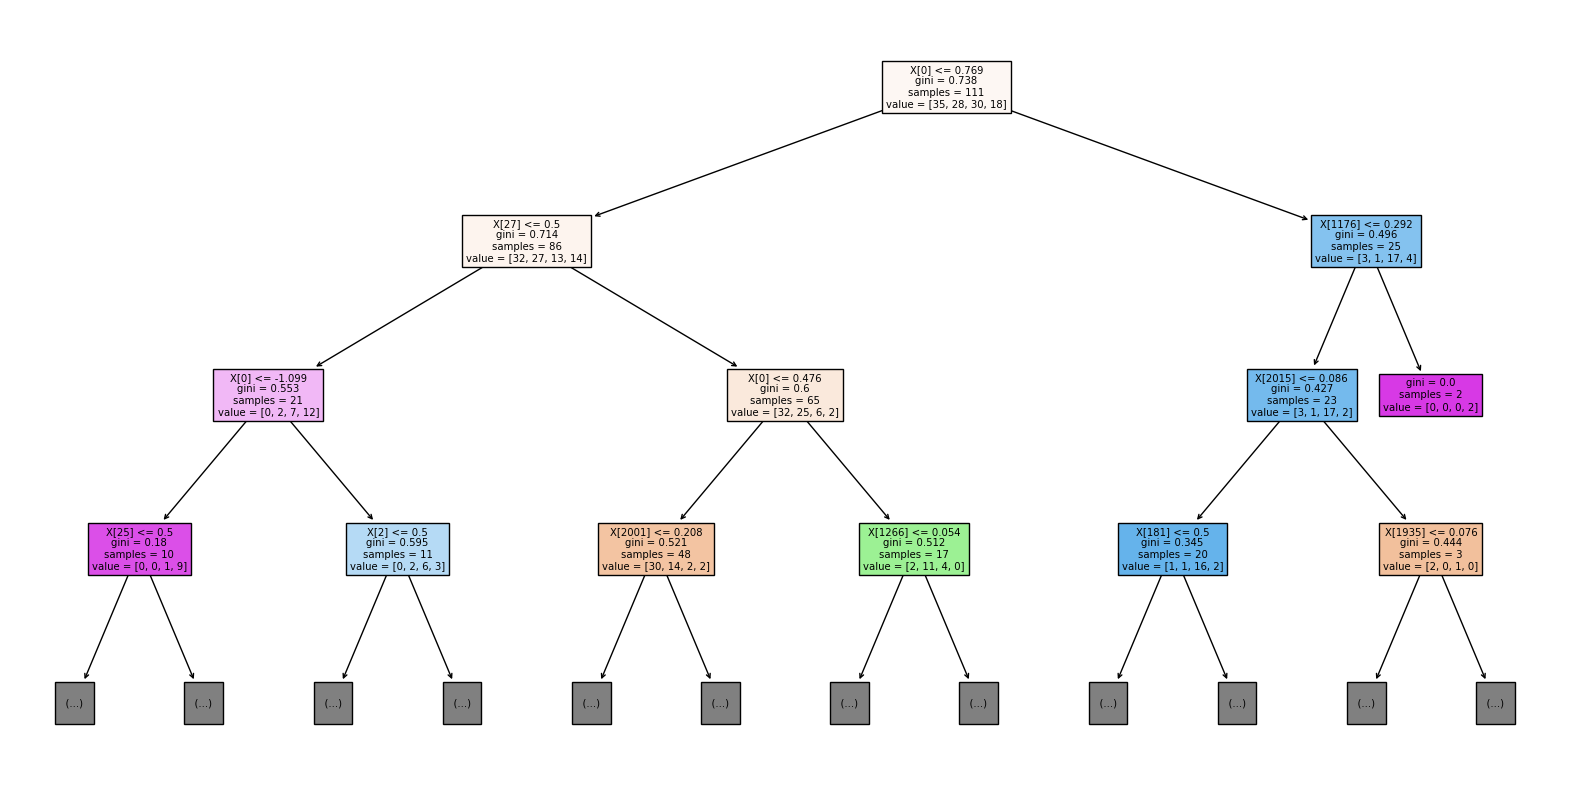

In [166]:


#Combine preprocessor with Decision Tree classifier
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Create X and Y
X = consistent_df[categorical_features + numerical_features + text_features]
Y = consistent_df['criticScore']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
model_dt.fit(X_train, Y_train)
    
Y_pred_dt = model_dt.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred_dt)
print("Mean Absolute Error: ", mae)
print("Accuracy: ", accuracy_score(Y_test, Y_pred_dt))
print(classification_report(Y_test, Y_pred_dt))
print(confusion_matrix(Y_test, Y_pred_dt))

# Fit a standalone DecisionTreeClassifier on preprocessed data
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)

classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_preprocessed, Y_train)

# Plotting the decision tree
plt.figure(figsize=(20,10))

# As you have many features in your data, the plot may become unreadable. 
# You may want to limit the depth of the tree for a simpler visualization.

tree.plot_tree(classifier, filled=True, max_depth=3) # limiting tree depth to 3 for simplicity
plt.show()



# K-NN

C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Minimum error at K = 15
Mean Absolute Error:  0.4642857142857143
Accuracy:  0.5714285714285714
              precision    recall  f1-score   support

           1       0.80      0.80      0.80        10
           2       0.12      0.25      0.17         4
           3       0.67      0.50      0.57        12
           4       1.00      0.50      0.67         2

    accuracy                           0.57        28
   macro avg       0.65      0.51      0.55        28
weighted avg       0.66      0.57      0.60        28

[[8 1 1 0]
 [2 1 1 0]
 [0 6 6 0]
 [0 0 1 1]]


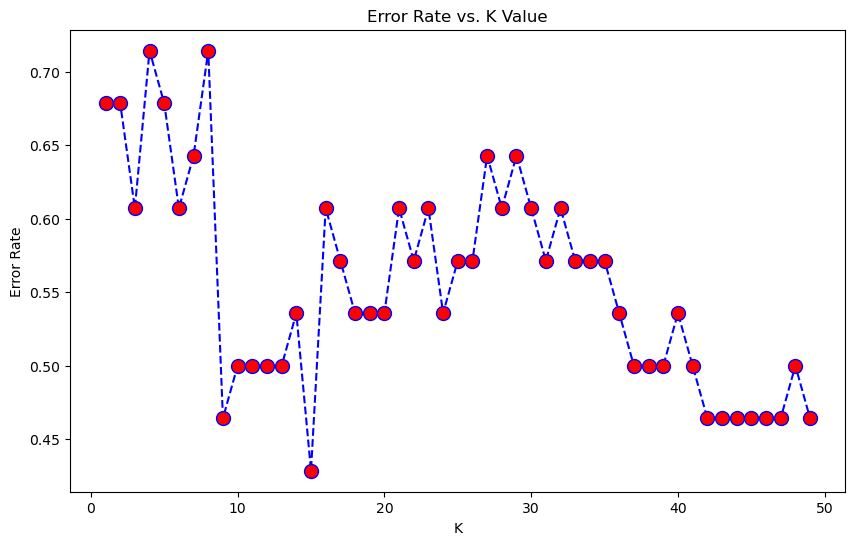

In [167]:


# Combine preprocessor with K-NN classifier
# Create X and Y
X = consistent_df[categorical_features + numerical_features + text_features]
Y = consistent_df['criticScore']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

error_rate = []
k_values = range(1,50)
for i in k_values:
    model_knn = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=i))
    ])
    model_knn.fit(X_train, Y_train)
    pred_i = model_knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

plt.figure(figsize=(10,6))

plt.plot(k_values, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

kmer = error_rate.index(min(error_rate)) + 1
print("Minimum error at K =", kmer)

# Evaluate the model with the optimal K
model_knn_opt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=kmer))
])
model_knn_opt.fit(X_train, Y_train)

Y_pred_knn_opt = model_knn_opt.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred_knn_opt)
print("Mean Absolute Error: ", mae)
print("Accuracy: ", accuracy_score(Y_test, Y_pred_knn_opt))
print(classification_report(Y_test, Y_pred_knn_opt))
print(confusion_matrix(Y_test, Y_pred_knn_opt))

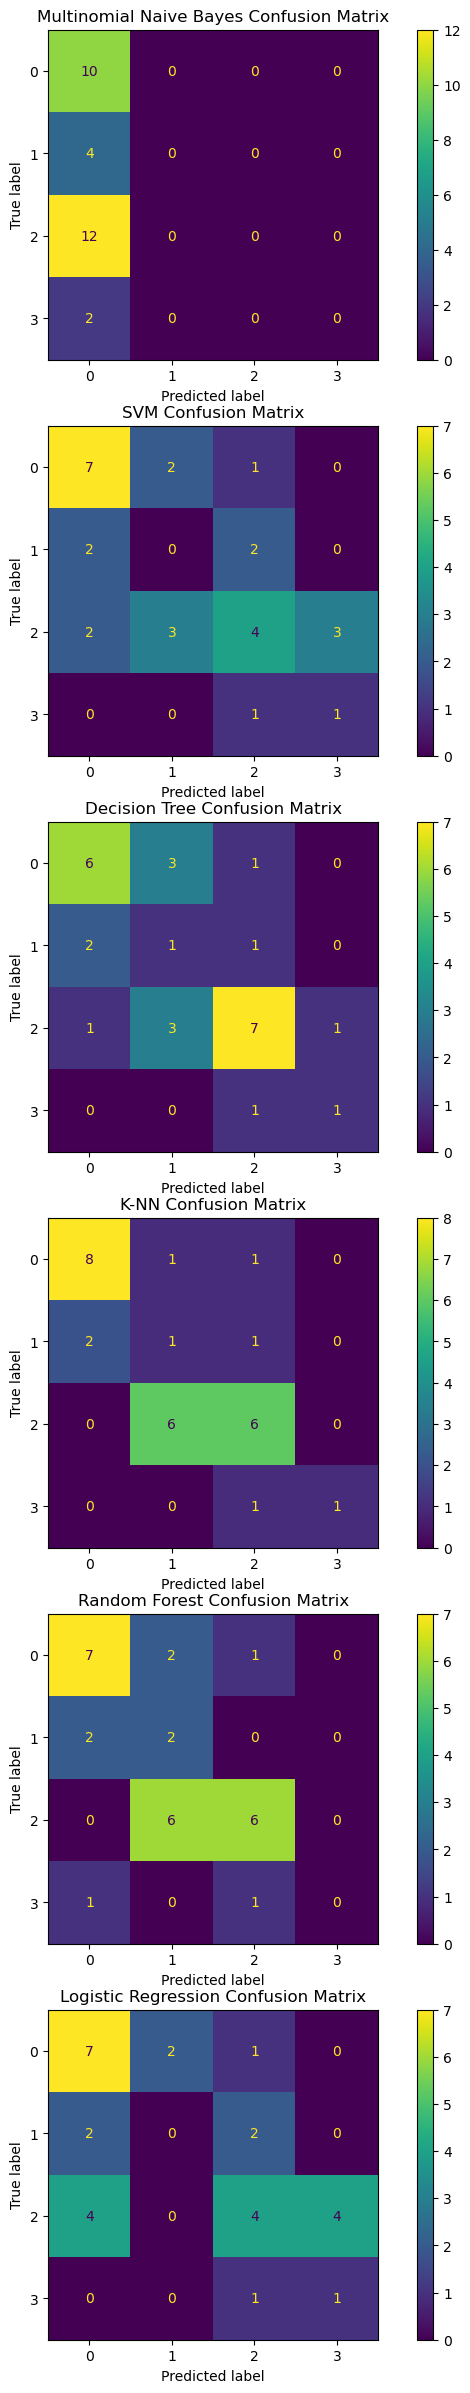

In [168]:



fig, axs = plt.subplots(6, 1, figsize=(10, 30))

# MultinomialNB
cm_nb = confusion_matrix(Y_test, Y_pred_mn)
ConfusionMatrixDisplay(cm_nb).plot(ax=axs[0])
axs[0].set_title('Multinomial Naive Bayes Confusion Matrix')

# SVM
cm_svm = confusion_matrix(Y_test, Y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot(ax=axs[1])
axs[1].set_title('SVM Confusion Matrix')

# Decision Trees
cm_dt = confusion_matrix(Y_test, Y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot(ax=axs[2])
axs[2].set_title('Decision Tree Confusion Matrix')

# K-NN
cm_knn = confusion_matrix(Y_test, Y_pred_knn_opt)
ConfusionMatrixDisplay(cm_knn).plot(ax=axs[3])
axs[3].set_title('K-NN Confusion Matrix')



# Logistic Regression
cm_lr = confusion_matrix(Y_test, Y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(ax=axs[5])
axs[5].set_title('Logistic Regression Confusion Matrix')

plt.show()

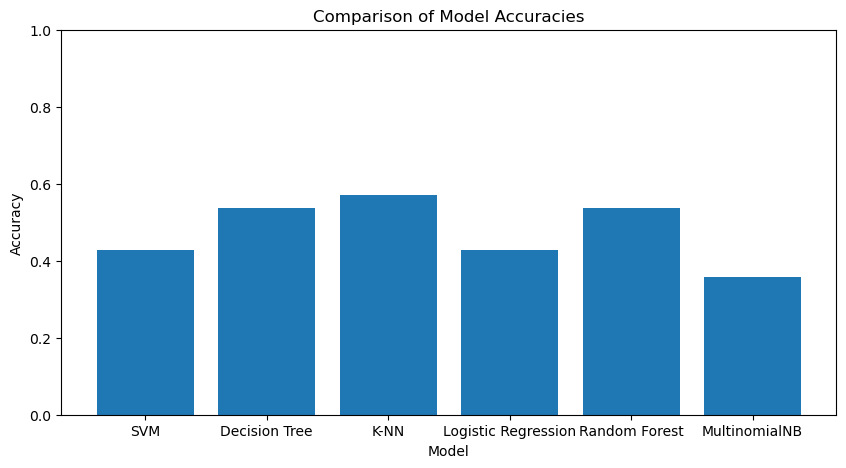

In [169]:
# Calculate accuracies
accuracies = {
    'SVM': accuracy_score(Y_test, Y_pred_svm),
    'Decision Tree': accuracy_score(Y_test, Y_pred_dt),
    'K-NN': accuracy_score(Y_test, Y_pred_knn_opt),
    'Logistic Regression': accuracy_score(Y_test, Y_pred_lr),
    'MultinomialNB': accuracy_score(Y_test, Y_pred_mn)
}

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])  # Adjust as per your needs
plt.show()

# Comparação dos Modelos 

C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alex-\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurt

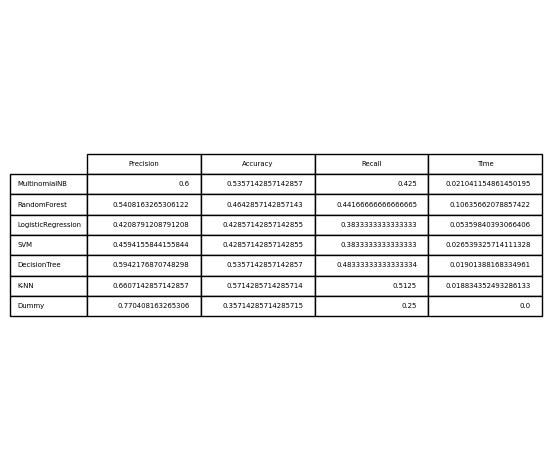

In [170]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score
import time

models = [model, model_lr, model_svm, model_dt, model_knn_opt]
model_names = ["MultinomialNB", "LogisticRegression", "SVM", "DecisionTree", "K-NN"]

# Empty lists to store metrics
precision_list = []
accuracy_list = []
recall_list = []
time_list = []

for i, model in enumerate(models):
    start = time.time()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    elapsed_time = time.time() - start

    precision = precision_score(Y_test, Y_pred, average='weighted')
    accuracy = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average='macro')

    precision_list.append(precision)
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    time_list.append(elapsed_time)

# Now add the DummyClassifier
start = time.time()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
Y_pred_dummy = dummy_clf.predict(X_test)
elapsed_time_dummy = time.time() - start

precision_dummy = precision_score(Y_test, Y_pred_dummy, average='weighted', zero_division=1)
accuracy_dummy = accuracy_score(Y_test, Y_pred_dummy)
recall_dummy = recall_score(Y_test, Y_pred_dummy, average='macro')

model_names.append("Dummy")
precision_list.append(precision_dummy)
accuracy_list.append(accuracy_dummy)
recall_list.append(recall_dummy)
time_list.append(elapsed_time_dummy)

fig, axs = plt.subplots()
fig.patch.set_visible(False)
axs.axis('off')
plt.table(cellText=list(zip(precision_list, accuracy_list, recall_list, time_list)), 
          rowLabels=model_names, colLabels=["Precision","Accuracy","Recall","Time"], loc='center')
fig.tight_layout()
plt.show()

